In [2]:
import numpy as np
import matplotlib.pyplot as plt
from kontrol import *
from kontrol.model import make_weight
from control import *
import dtt2hdf

In [147]:
items = dtt2hdf.read_diaggui('./data/BS_IP_noise_20200721.xml')
f = items.results.PSD['K1:VIS-BS_IP_BLEND_ACCL_IN1'].FHz
noise_lvdtt_data = items.results.PSD['K1:VIS-BS_IP_BLEND_LVDTT_IN1'].PSD[0]
noise_geot_data = items.results.PSD['K1:VIS-BS_IP_BLEND_ACCT_IN1'].PSD[0]

mask = (f > 1e-2) & (f < 1e1)
f = f[mask]
noise_lvdtt_data = noise_lvdtt_data[mask]
noise_geot_data = noise_geot_data[mask]

Text(0.5, 0, 'Frequency (Hz)')

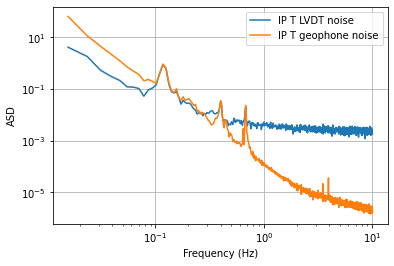

In [15]:
plt.loglog(f, noise_lvdtt_data, label='IP T LVDT noise')
plt.loglog(f, noise_geot_data, label='IP T geophone noise')
plt.legend(loc=0)
plt.grid()
plt.ylabel('ASD')
plt.xlabel('Frequency (Hz)')

In [27]:
def cost(args, reference_model, f, data, weight=None):
    if weight is None:
        weight = np.ones_like(f)
    model_num = args[0:len(reference_model.num[0][0])]
    model_den = args[len(reference_model.num[0][0]):len(args)]
    model = tf(model_num, model_den)
    residue = sum(((abs(model.horner(2*np.pi*f*1j)[0][0])-data)/abs(data))**2*weight)
    return(residue)

In [46]:
from scipy.optimize import minimize
noise_lvdtt_tf = tf([1,2,3,4,5,6],[1,2,3,4,5,6])
x0 = list(noise_lvdtt_tf.num[0][0])+list(noise_lvdtt_tf.den[0][0])
weight = make_weight(f, ((0.07, 0.9), 0))
res = minimize(cost, args=(noise_lvdtt_tf, f, noise_lvdtt_data, weight), x0=x0)
res.x

array([-4.32929976e-03,  1.09247804e-01,  1.75716435e-02,  1.93369129e+01,
        1.52528247e+02, -1.24482356e+02,  2.03520179e+00, -4.94326536e+01,
        3.73467638e+02, -9.18788100e+03,  2.61392708e+01, -1.20078445e+02])

In [51]:
noise_geot_tf = tf([1,2,3,4,5],[1,2,3,4,5,6])
x0 = list(noise_geot_tf.num[0][0])+list(noise_geot_tf.den[0][0])
weight = make_weight(f, ((0.07, 0.9), 0))
res = minimize(cost, args=(noise_geot_tf, f, noise_geot_data, weight), x0=x0)
res.x

array([ 1.02350981e-07, -4.04097319e-02,  8.61603423e-01, -9.94982268e+00,
        1.22283911e+01,  1.06055449e+00,  3.11836096e+02,  3.18296152e+02,
       -6.33870797e+01,  1.77895813e+00, -7.84834231e-01])

Text(0.5, 0, 'Frequency (Hz)')

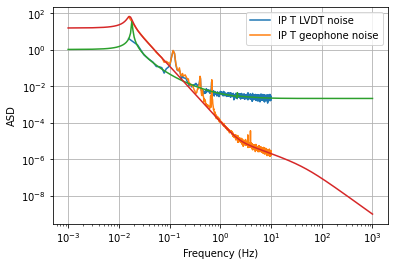

In [149]:
noise_lvdtt_fit = tf([-4.32929976e-03,  1.09247804e-01,  1.75716435e-02,  1.93369129e+01,
        1.52528247e+02, -1.24482356e+02],  [2.03520179e+00, -4.94326536e+01,
        3.73467638e+02, -9.18788100e+03,  2.61392708e+01, -1.20078445e+02])
noise_geot_fit = tf([ 1.02350981e-07, -4.04097319e-02,  8.61603423e-01, -9.94982268e+00,
        1.22283911e+01],  [1.06055449e+00,  3.11836096e+02,  3.18296152e+02,
       -6.33870797e+01,  1.77895813e+00, -7.84834231e-01])
plt.loglog(f, noise_lvdtt_data, label='IP T LVDT noise')
plt.loglog(f, noise_geot_data, label='IP T geophone noise')
_f=np.linspace(1e-3,1e3,1000000)
plt.loglog(_f, abs(noise_lvdtt_fit.horner(2*np.pi*1j*_f)[0][0]))
plt.loglog(_f, abs(noise_geot_fit.horner(2*np.pi*1j*_f)[0][0]))
# plt.loglog(f, abs(stable_noise_lvdtt.horner(2*np.pi*1j*f)[0][0]))

plt.legend(loc=0)
plt.grid()
plt.ylabel('ASD')
plt.xlabel('Frequency (Hz)')

In [145]:
def remove_unstable(unstable_tf, remove_unstable_zeros=True):
    """Negate the positive real parts of the poles and zeros of a transfer function.
    
    Parameters
    ----------
        untable_tf: control.xferfcn.TransferFunction
            The transfer function which contains unstable poles or zeros.
        remove_unstable_zeros: boolean, optional
            Set True to remove unstable zeros as well.
    
    Returns
    -------
        stable_tf: control.xferfcn.TransferFuncion
            The modified transfer function with flipped unstable poles and zeros.
    """
    stable_tf = tf([1], [1])
    
    for pole in unstable_tf.pole():
#         print(pole)
        x = np.real(pole)
        y = np.imag(pole)
        if abs(y/x) < 1e-10:
            y = 0
        if x > 0:
            wn = x + 1j*y
        else:
            wn = -x + 1j*y
        stable_tf *= tf([1], [1/wn, 1])
        
    for zero in unstable_tf.zero():
#         print(zero)
        x = np.real(zero)
        y = np.imag(zero)
        if abs(y/x) < 1e-10:
            y = 0
        if x > 0:
            wn = x + 1j*y
        else:
            wn = -x + 1j*y
        stable_tf *= tf([1/wn, 1], [1])
    
    stable_tf *= float(unstable_tf.dcgain())
    
    return(stable_tf)

In [114]:
stable_noise_lvdtt.pole()

C:\Users\tec\anaconda3\envs\kontrol\lib\site-packages\control\xferfcn.py:919: ComplexWarning: Casting complex values to real discards the imaginary part
  den[j, :maxindex+1] = poly(poles[j])
C:\Users\tec\anaconda3\envs\kontrol\lib\site-packages\control\xferfcn.py:935: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly


array([-2.43621255e+01+0.j       , -1.94830355e-02+1.2473168j,
       -1.94830355e-02-1.2473168j, -3.78089557e-02+0.j       ,
       -1.15711528e-03+0.j       ])

In [115]:
noise_lvdtt_fit.pole()

array([ 2.43621255e+01 +0.j        , -3.78089557e-02+13.61159404j,
       -3.78089557e-02-13.61159404j,  1.15711528e-03 +0.11432423j,
        1.15711528e-03 -0.11432423j])

In [110]:
stable_noise_lvdtt.dcgain()

C:\Users\tec\anaconda3\envs\kontrol\lib\site-packages\control\xferfcn.py:1018: ComplexWarning: Casting complex values to real discards the imaginary part
  gain[i][j] = num / den


array(1.03667528)

In [58]:
type(noise_lvdtt_fit)

control.xferfcn.TransferFunction

In [111]:
noise_lvdtt_fit.dcgain()


array(1.03667528)

In [134]:
from kontrol.filter import h2complementary
h1, h2 = h2complementary(remove_unstable(noise_lvdtt_fit), remove_unstable(noise_geot_fit))

(24.36212547867669+0j)
(-0.03780895568901377+13.61159403653764j)
(-0.03780895568901377-13.61159403653764j)
(0.0011571152817430519+0.11432423255838721j)
(0.0011571152817430519-0.11432423255838721j)
(31.11666222619546+0j)
(0.045268736218750494+13.58382698281239j)
(0.045268736218750494-13.58382698281239j)
(-6.718099995917028+0j)
(0.7454209025285488+0j)
(-293.00620434705297+0j)
(-1.2003707715581422+0j)
(0.19660963916300866+0j)
(-0.01061096164245369+0.10290280757317898j)
(-0.01061096164245369-0.10290280757317898j)
(394793.9644172256+0j)
(9.96903564297481+10.920496730736803j)
(9.96903564297481-10.920496730736803j)
(1.384137808195281+0j)


C:\Users\tec\anaconda3\envs\kontrol\lib\site-packages\control\xferfcn.py:935: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly


In [142]:
n1 = remove_unstable(noise_lvdtt_fit)
n2 = remove_unstable(noise_geot_fit)
p = [[tf([0],[1]), n2, tf([1],[1])],
         [n1, -n2, tf([0],[1])]]
#     p = [[n1, -n1],
#          [tf([0],[1]), n2],
#          [tf([1],[1]), tf([0],[1])]]
p = tfmatrix2tf(p)
# h1 = tf(h2syn(ss(p), 1, 1))
# h2 = 1 - h1
K, CL, gam, rcond=hinfsyn(ss(p), 1, 1)
h1=tf(K)
h2=1-h1

(24.36212547867669+0j)
(-0.03780895568901377+13.61159403653764j)
(-0.03780895568901377-13.61159403653764j)
(0.0011571152817430519+0.11432423255838721j)
(0.0011571152817430519-0.11432423255838721j)
(31.11666222619546+0j)
(0.045268736218750494+13.58382698281239j)
(0.045268736218750494-13.58382698281239j)
(-6.718099995917028+0j)
(0.7454209025285488+0j)
(-293.00620434705297+0j)
(-1.2003707715581422+0j)
(0.19660963916300866+0j)
(-0.01061096164245369+0.10290280757317898j)
(-0.01061096164245369-0.10290280757317898j)
(394793.9644172256+0j)
(9.96903564297481+10.920496730736803j)
(9.96903564297481-10.920496730736803j)
(1.384137808195281+0j)


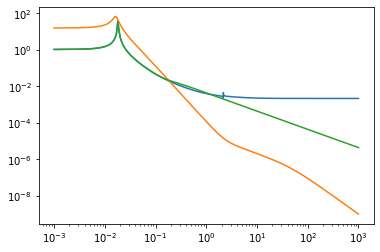

In [153]:
# f=np.logspace(-3,3,1000)
# plt.loglog(_f, abs(h1.horner(2*np.pi*1j*_f)[0][0]))
# plt.loglog(_f, abs(h2.horner(2*np.pi*1j*_f)[0][0]))
plt.loglog(_f, abs(noise_lvdtt_fit.horner(2*np.pi*1j*_f)[0][0]))
plt.loglog(_f, abs(noise_geot_fit.horner(2*np.pi*1j*_f)[0][0]))
plt.loglog(_f, quad_sum(abs(noise_lvdtt_fit.horner(2*np.pi*1j*_f)[0][0])*abs(h1.horner(2*np.pi*1j*_f)[0][0]),
                        abs(noise_geot_fit.horner(2*np.pi*1j*_f)[0][0])*abs(h2.horner(2*np.pi*1j*_f)[0][0])))

In [39]:
noise_lvdtt_fit.pole()

array([-1.28800324e+01+0.j        ,  1.02358516e-07+0.75129115j,
        1.02358516e-07-0.75129115j, -1.41929067e-06+0.11407442j,
       -1.41929067e-06-0.11407442j])

In [7]:
# def make_weight(x, *segments, default_weight=1.):
#     """Make weighting functions for data fitting
    
#     Parameters
#     ----------
#         x: list or np.ndarray
#             The data points for evaluation
#         *segments: tuples of (tuple of (float, float), float)
#             Set weights values for segments of the data. 
#             The first entry specify the bound of the segment.
#             The second entry specify the weight of the segment.
#             Use np.inf for unbounded segments.
#         default_weight: float, optional
#             The default value of the weighting function.
#             Defaults to be 1.
    
#     Returns
#     -------
#         weight: np.ndarray
#             The weighting function as specfied.
#     """

#     weight = np.ones_like(x) * default_weight
    
#     for seg in segments:
#         lower = seg[0][0]
#         upper = seg[0][1]
#         weight_val = seg[1]
#         if lower > upper:
#             _ = lower
#             lower = upper
#             upper = _
#         mask_bool = (x >= lower) & (x <= upper) 
#         mask_value = mask_bool * weight_val
#         weight *= np.logical_not(mask_bool)
#         weight += mask_value
    
#     return(weight)

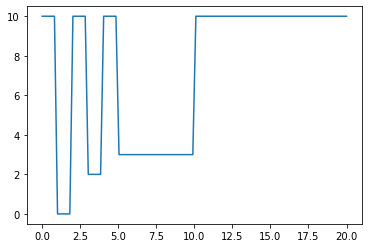

In [8]:
x = np.linspace(0,20, 100)
weight = make_weight(x, ((1, 2), 0), ((3, 4), 2), ((5, 10), 3), default_weight=10)
plt.plot(x, weight)
# plt.plot(weight)

In [37]:
a=[1,2,3,4]
a[1:3]=[4,5]
a

[1, 4, 5, 4]

In [45]:
mask=(f>0)&(f<10)
f*np.logical_not(mask)

array([  0.        ,   0.        ,   0.        , ...,  99.99218628,
        99.99999939, 100.0078125 ])